In [1]:
#!/usr/bin/env python3
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from model import *
from visual_functions import *
from sweep_configs import *
from sklearn.model_selection import train_test_split
from wandb.keras import WandbCallback
from train import *
%matplotlib inline

## ---------------------- load data ----------------------------------------
ins, os, hpr, rn = (72,32,1), 15, rand.randint(24, 44), 0.08
gen = SynthGen(ins, os, hpr, rn)
X, y = gen.create_dataset(1000)

Welcome to JupyROOT 6.26/00
Creating dataset...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1418.57it/s]


## Toymodel with new dimensions (72x32)

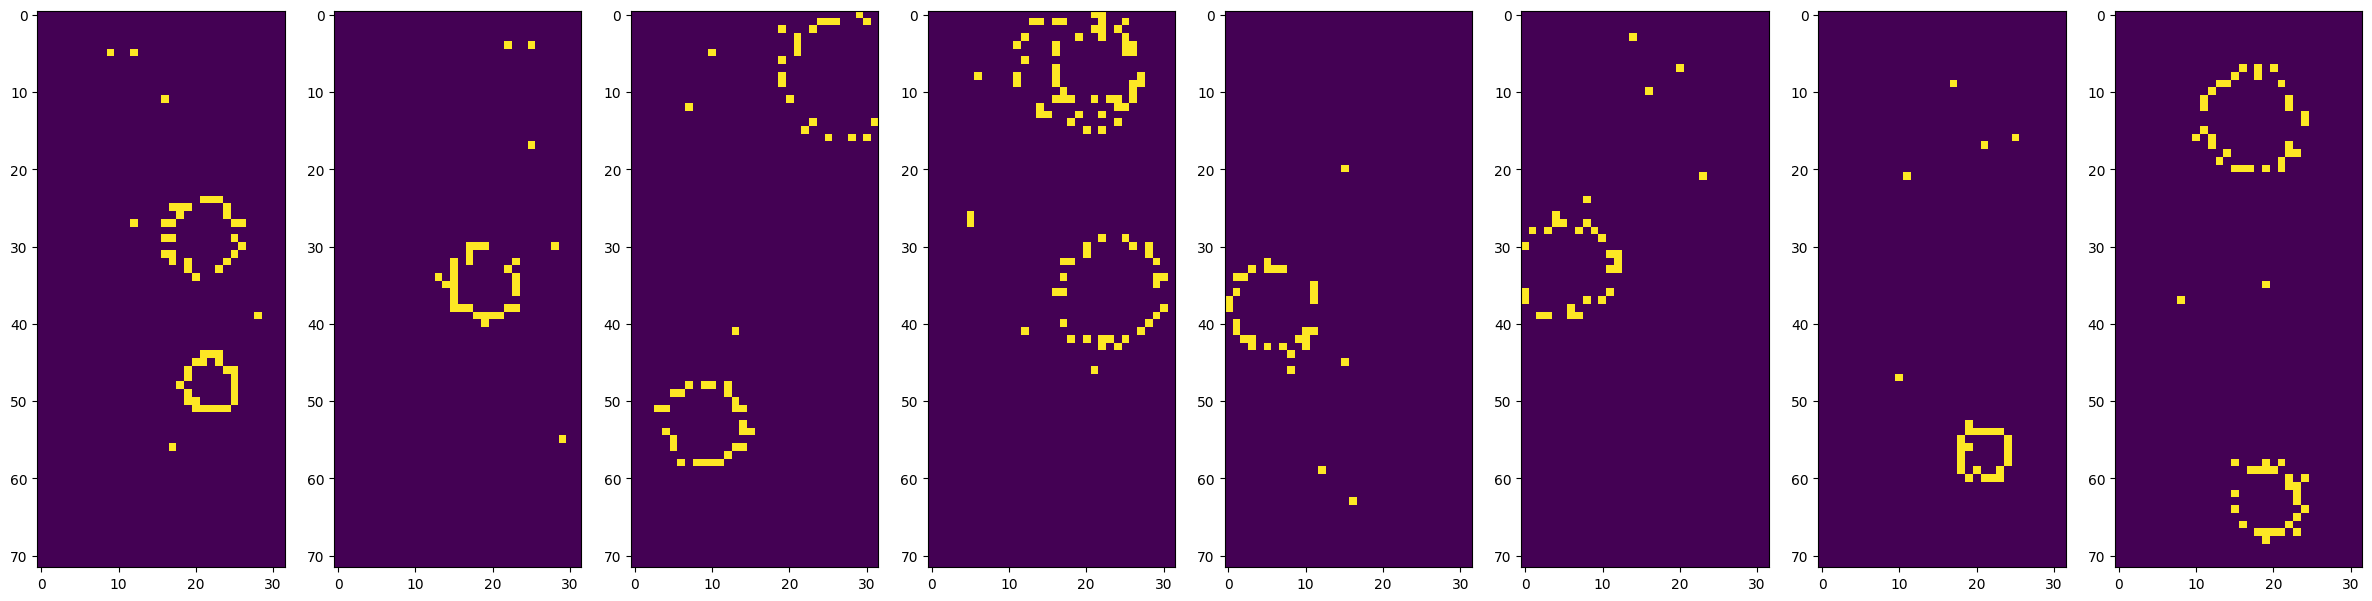

In [2]:
for i in range(1):
    display_data(X, i)
#    plt.imshow(plot_single_event(displays[i], params[i]))
#    plt.show()

## Real/Sim data (mcbm)

load data from  datasets/hits_true.txt  -> 20000  events loaded
(20000, 72, 32, 1)


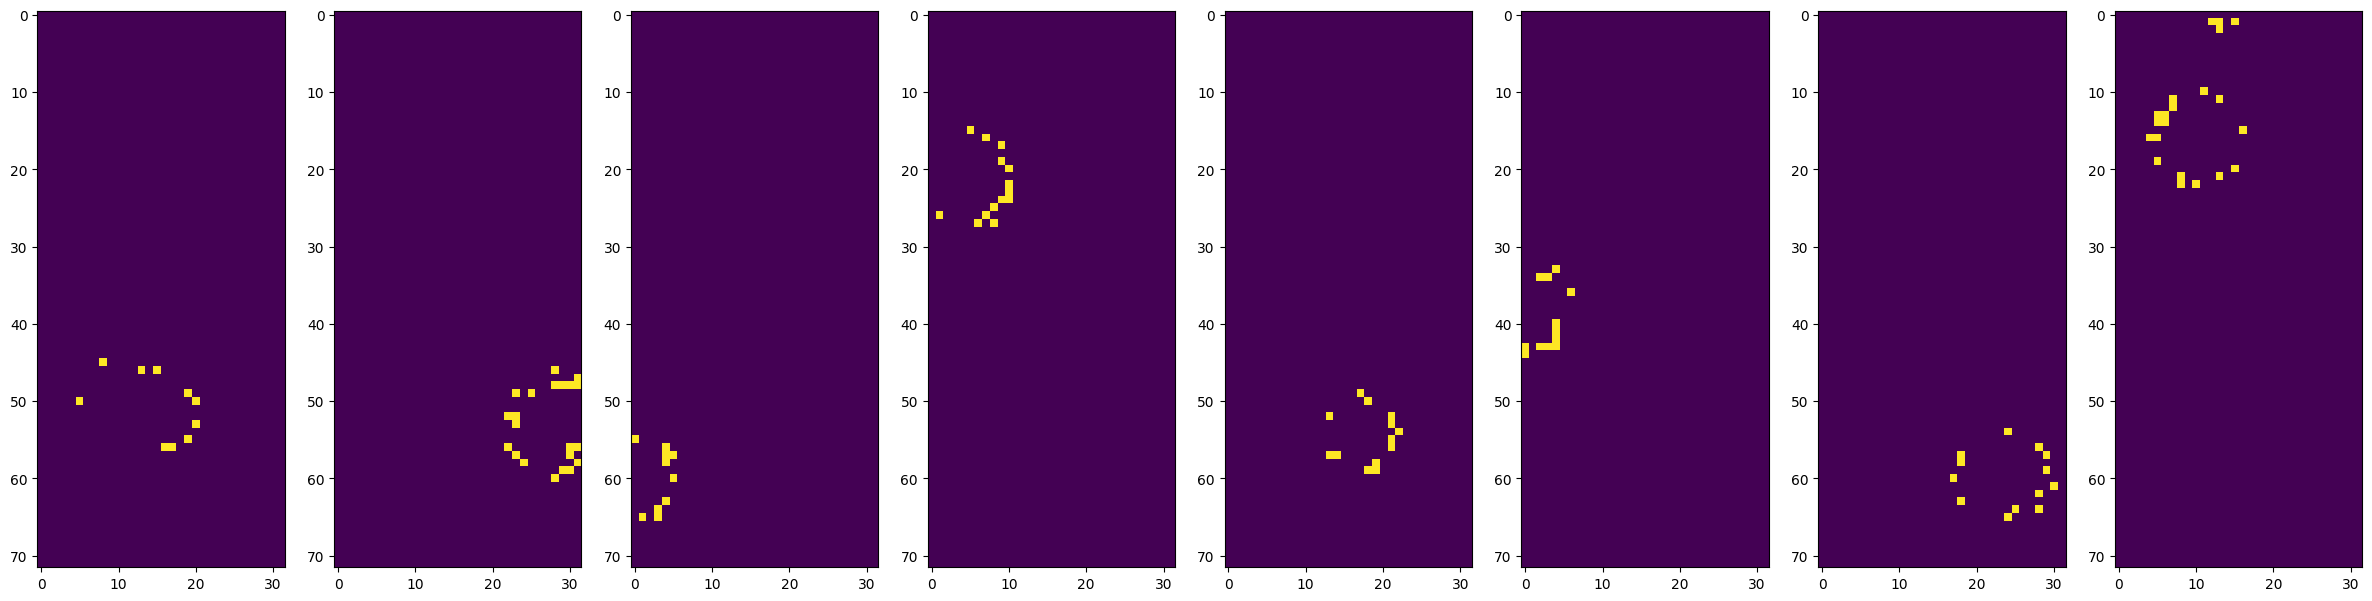

2022-04-04 15:45:36.544644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 15:45:36.570165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 15:45:36.570319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 15:45:36.570900: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
# load data file and some preprocessing
def loadDataFile(datafile, pixel_x = 32, pixel_y = 72):
    with open(datafile, 'r') as temp_f:
        col_count = [ len(l.split(",")) for l in temp_f.readlines() ]
    column_names = [i for i in range(0, max(col_count))]
    hits = pd.read_csv(datafile,header=None ,index_col=0,comment='#',
                       delimiter=",", nrows=
                       20000,names=column_names).values.astype('int32')
    hits[hits < 0] = 0
    hits_temp = np.zeros([len(hits[:,0]), pixel_x*pixel_y])
    for i in range(len(hits[:,0])):
        for j in range(len(hits[0,:])):
            if hits[i,j]==0:
                break
            hits_temp[i,hits[i,j]-1]+=1
    hits_temp = tf.reshape(hits_temp, [len(hits[:,0]), pixel_y, pixel_x])
    hits_temp = tf.clip_by_value(hits_temp, clip_value_min=0., clip_value_max=1.)
    hits = tf.cast(hits_temp[..., tf.newaxis],dtype=tf.float32)
    print('load data from  ' + datafile + '  -> ' + str(len(hits[:])) + '  events loaded' )
    return hits

hits_true = loadDataFile("datasets/hits_true.txt")
print(hits_true.shape)
for i in range(1):
    display_data(hits_true, i)

## Best model so far

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

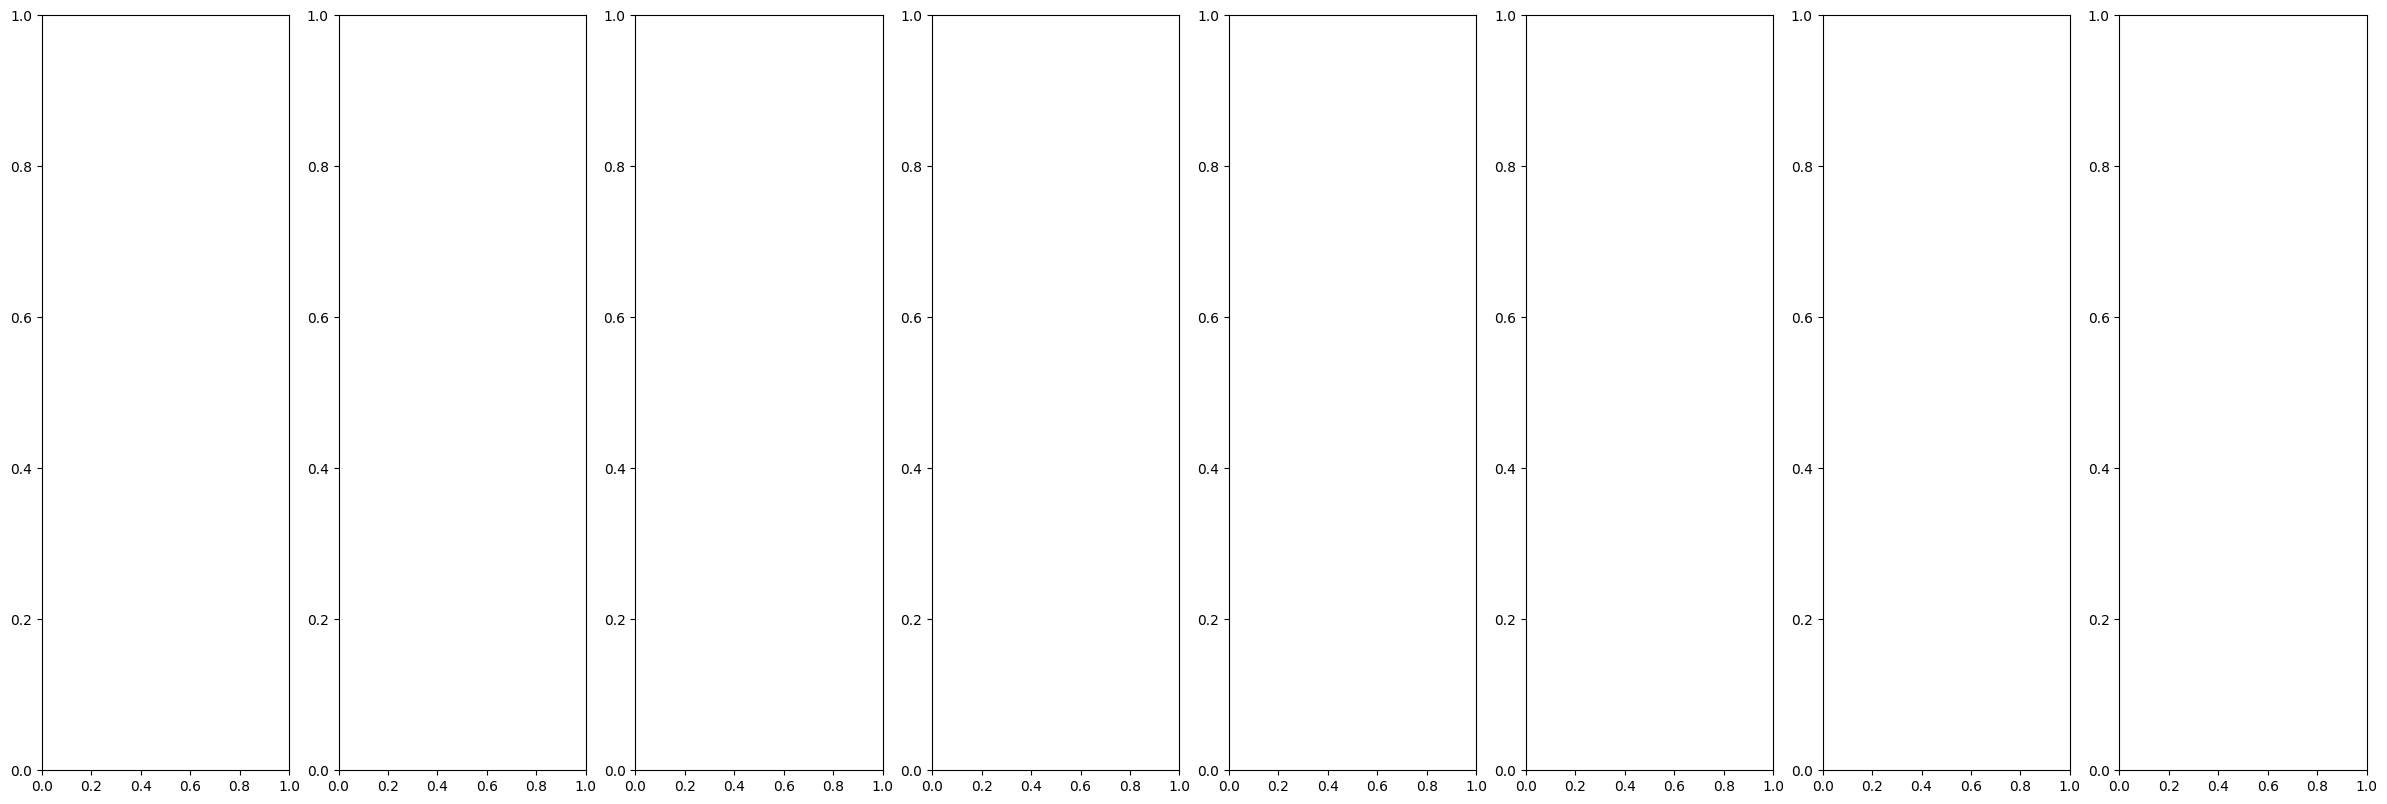

2022-04-04 15:45:45.484468: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


In [4]:
model = tf.keras.models.load_model("models/bmsf.model")
#model = tf.keras.models.load_model("models/bmsf.model")
#model = tf.keras.models.load_model("models/checkpoints/202204031255")j

show_predict(np.array(hits_true[:200]), model, 1, 8, 0)#, "fig{}".format(i))
    
#for i in range(10):
#    show_predict(np.array(hits_true[:200]), model, i)#, "fig{}".format(i))
#    show_predict(X, model, i)#, "fig{}".format(i))

#from tensorflow.keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir="LR")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 32, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 72, 32, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 32, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 16, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 36, 16, 32)        9248      
                                                             

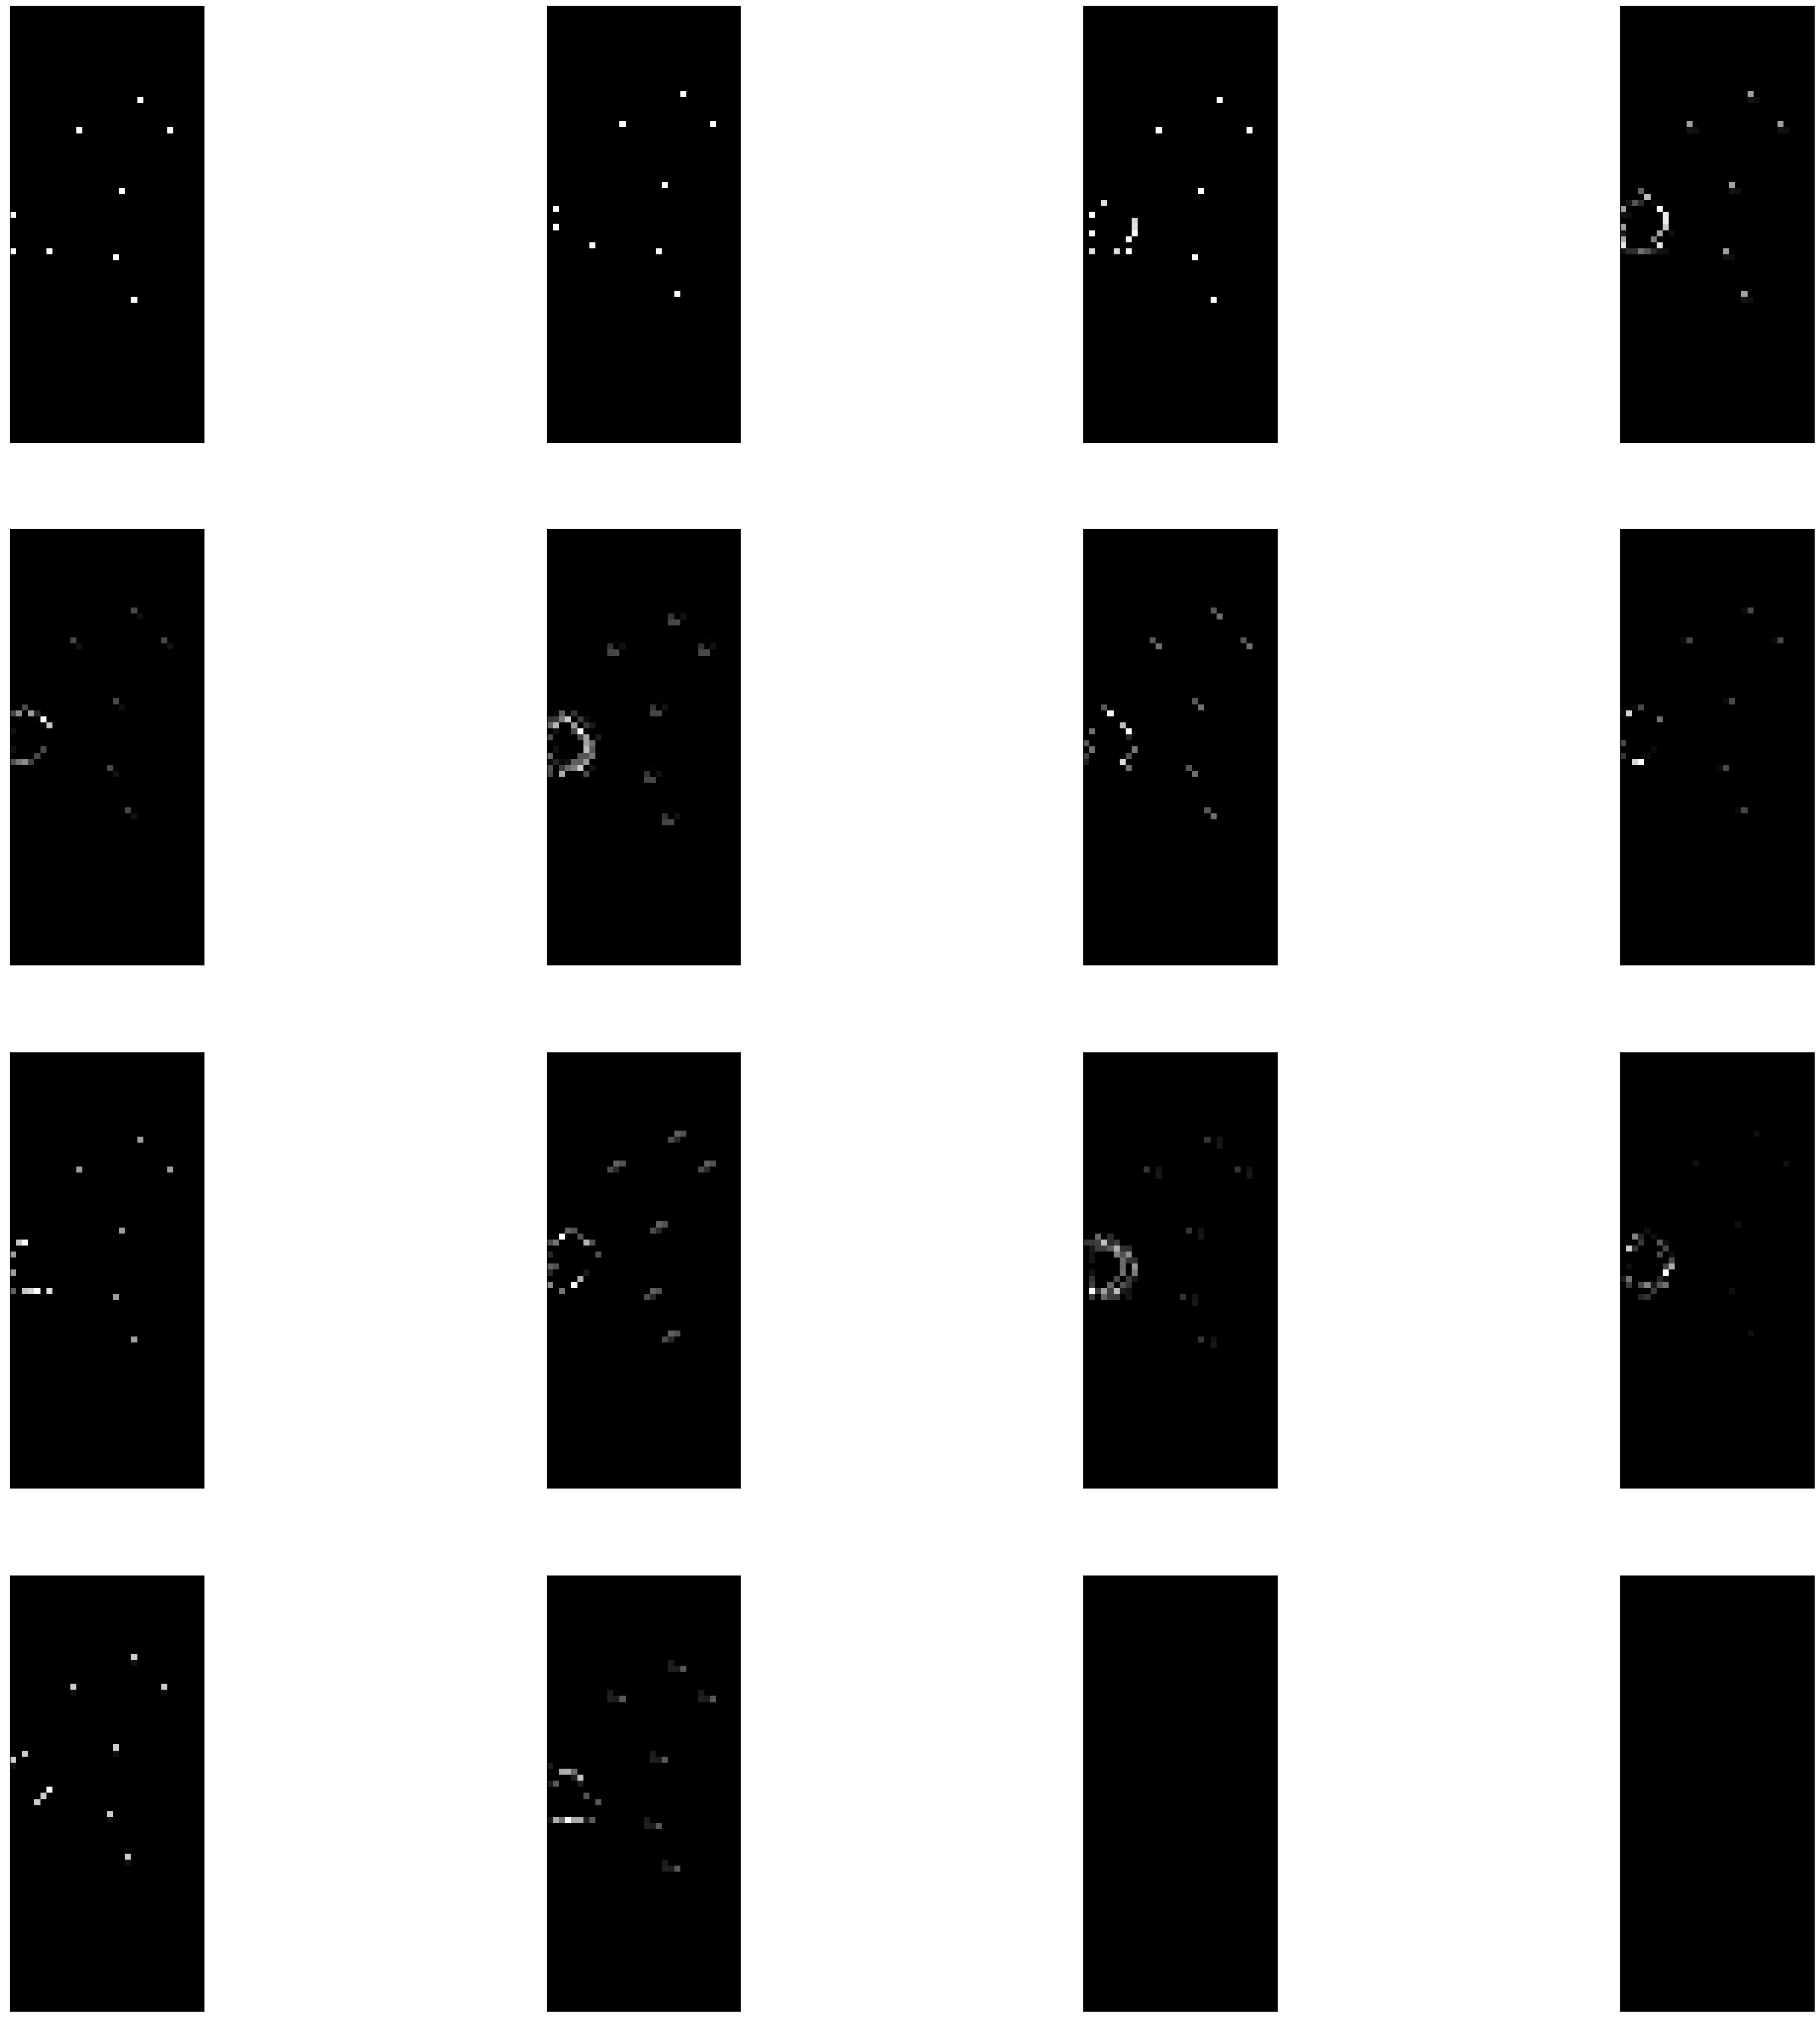

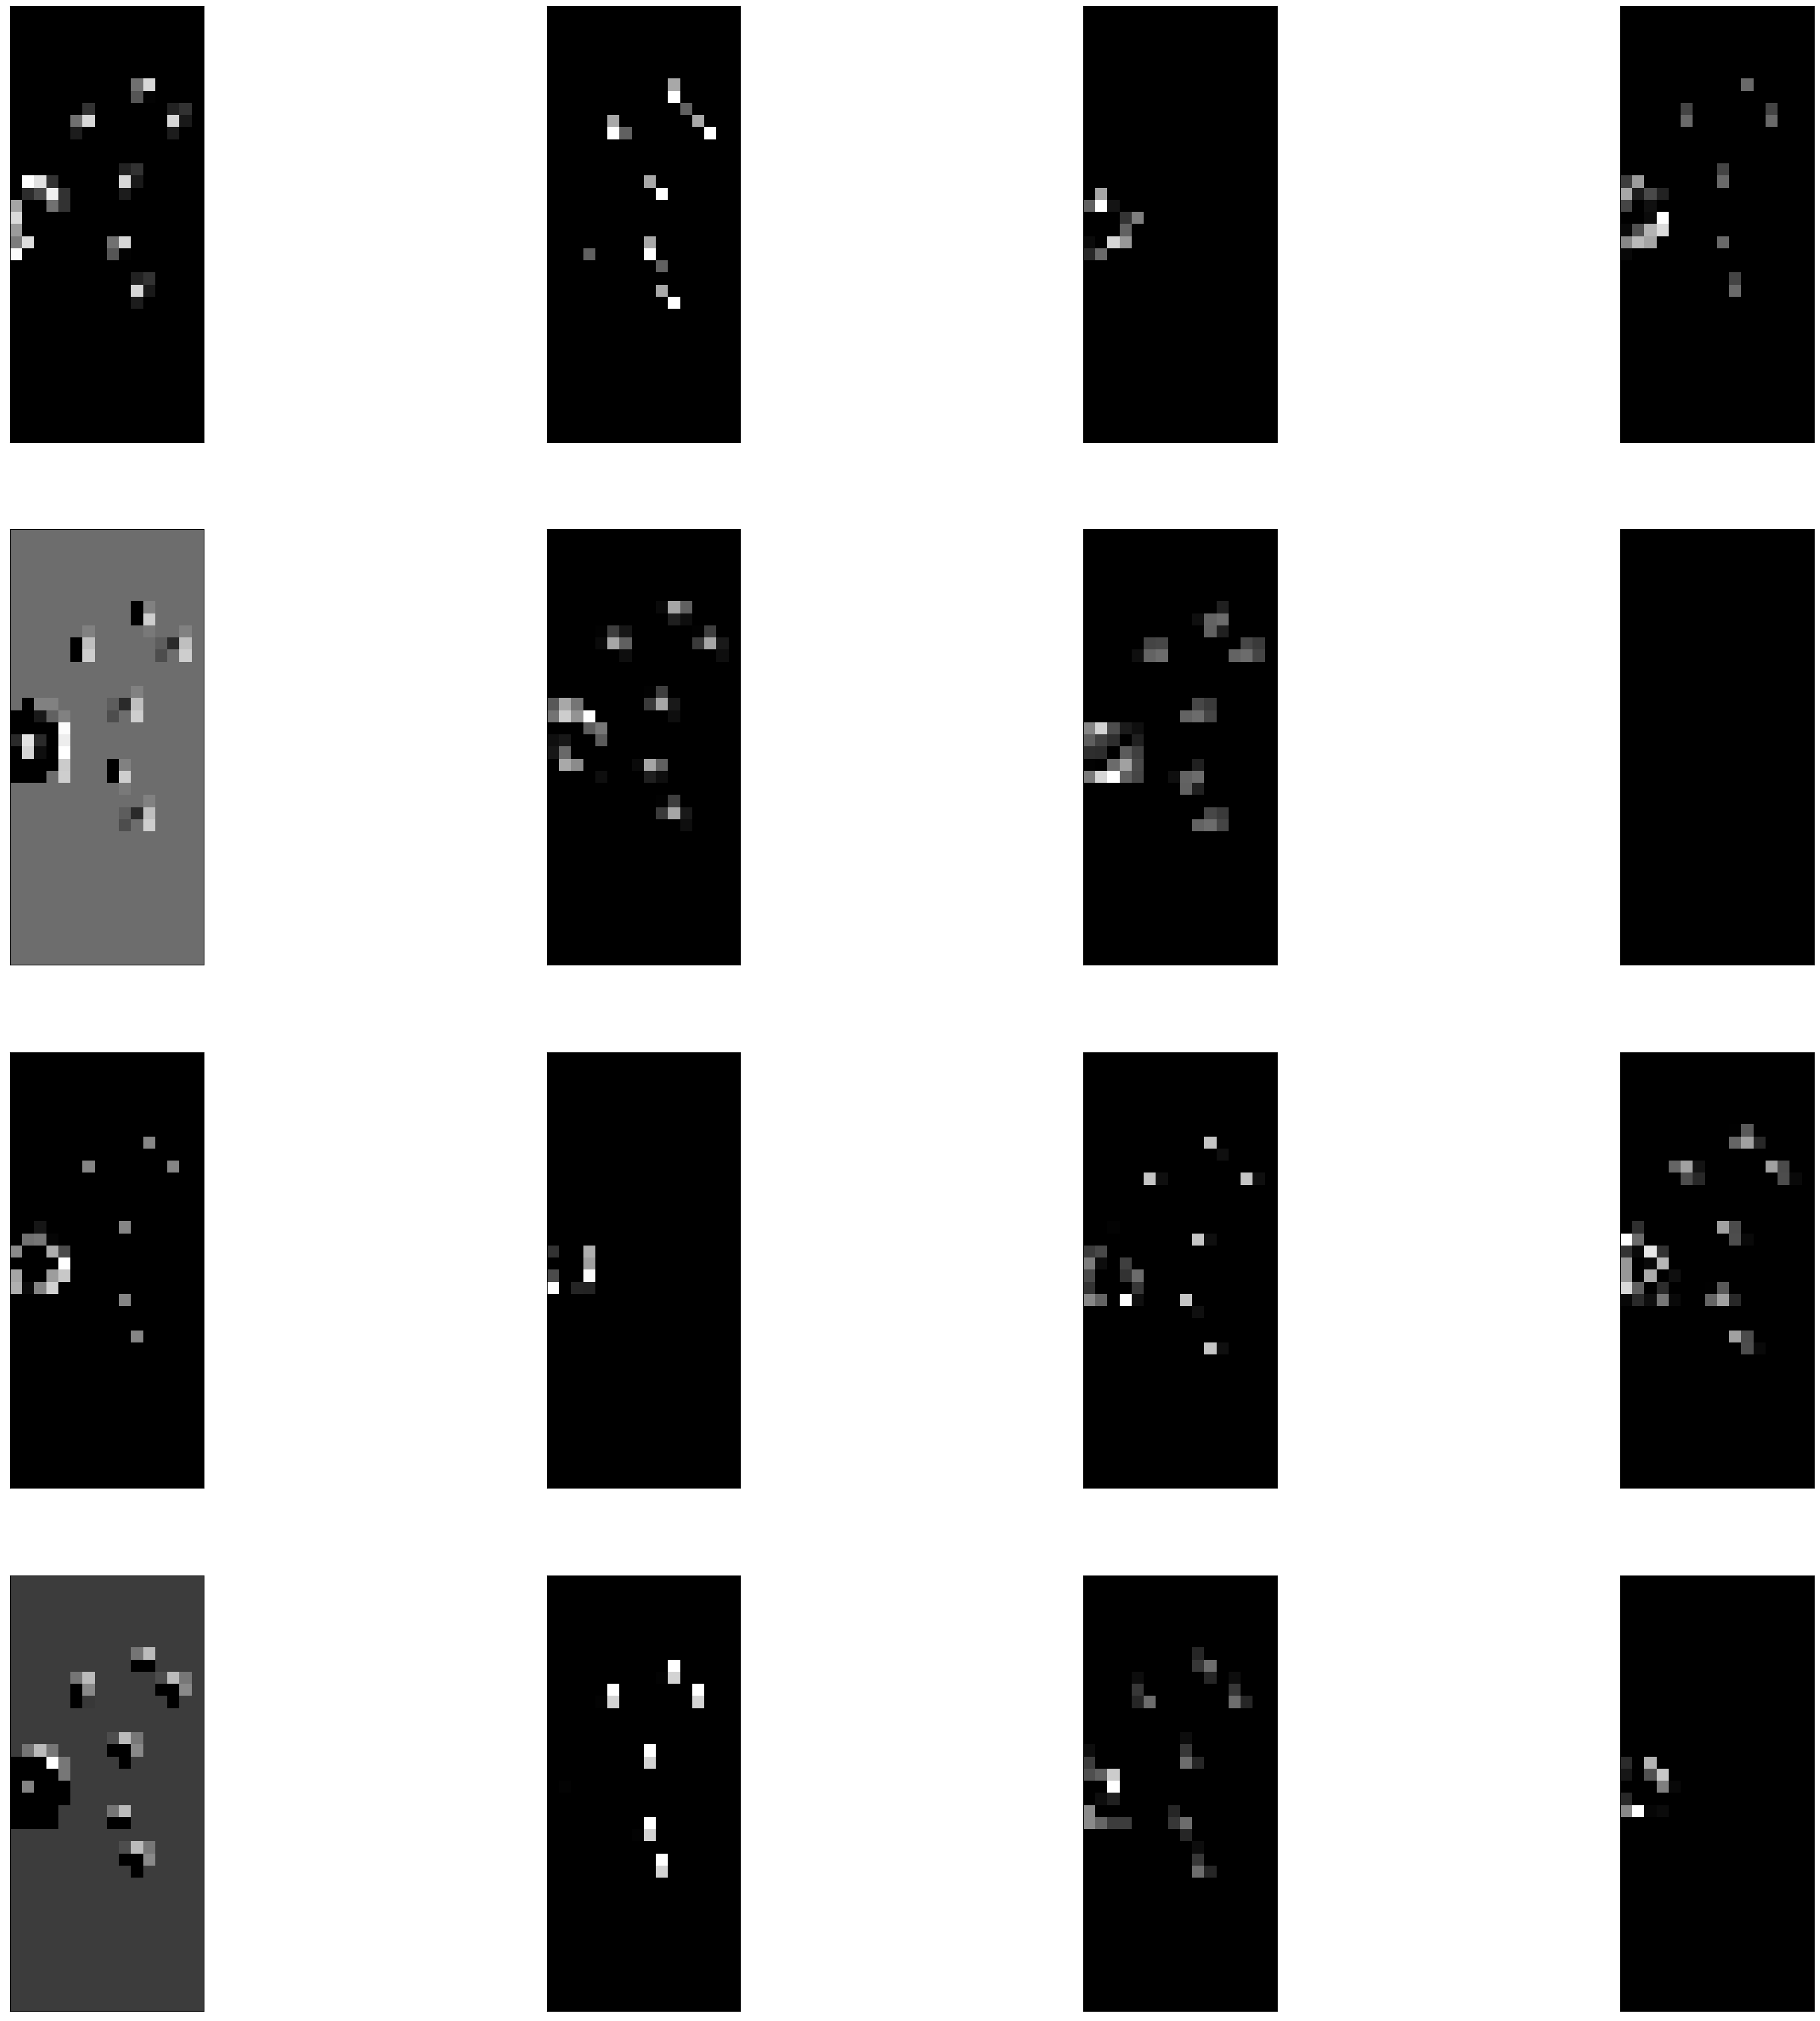

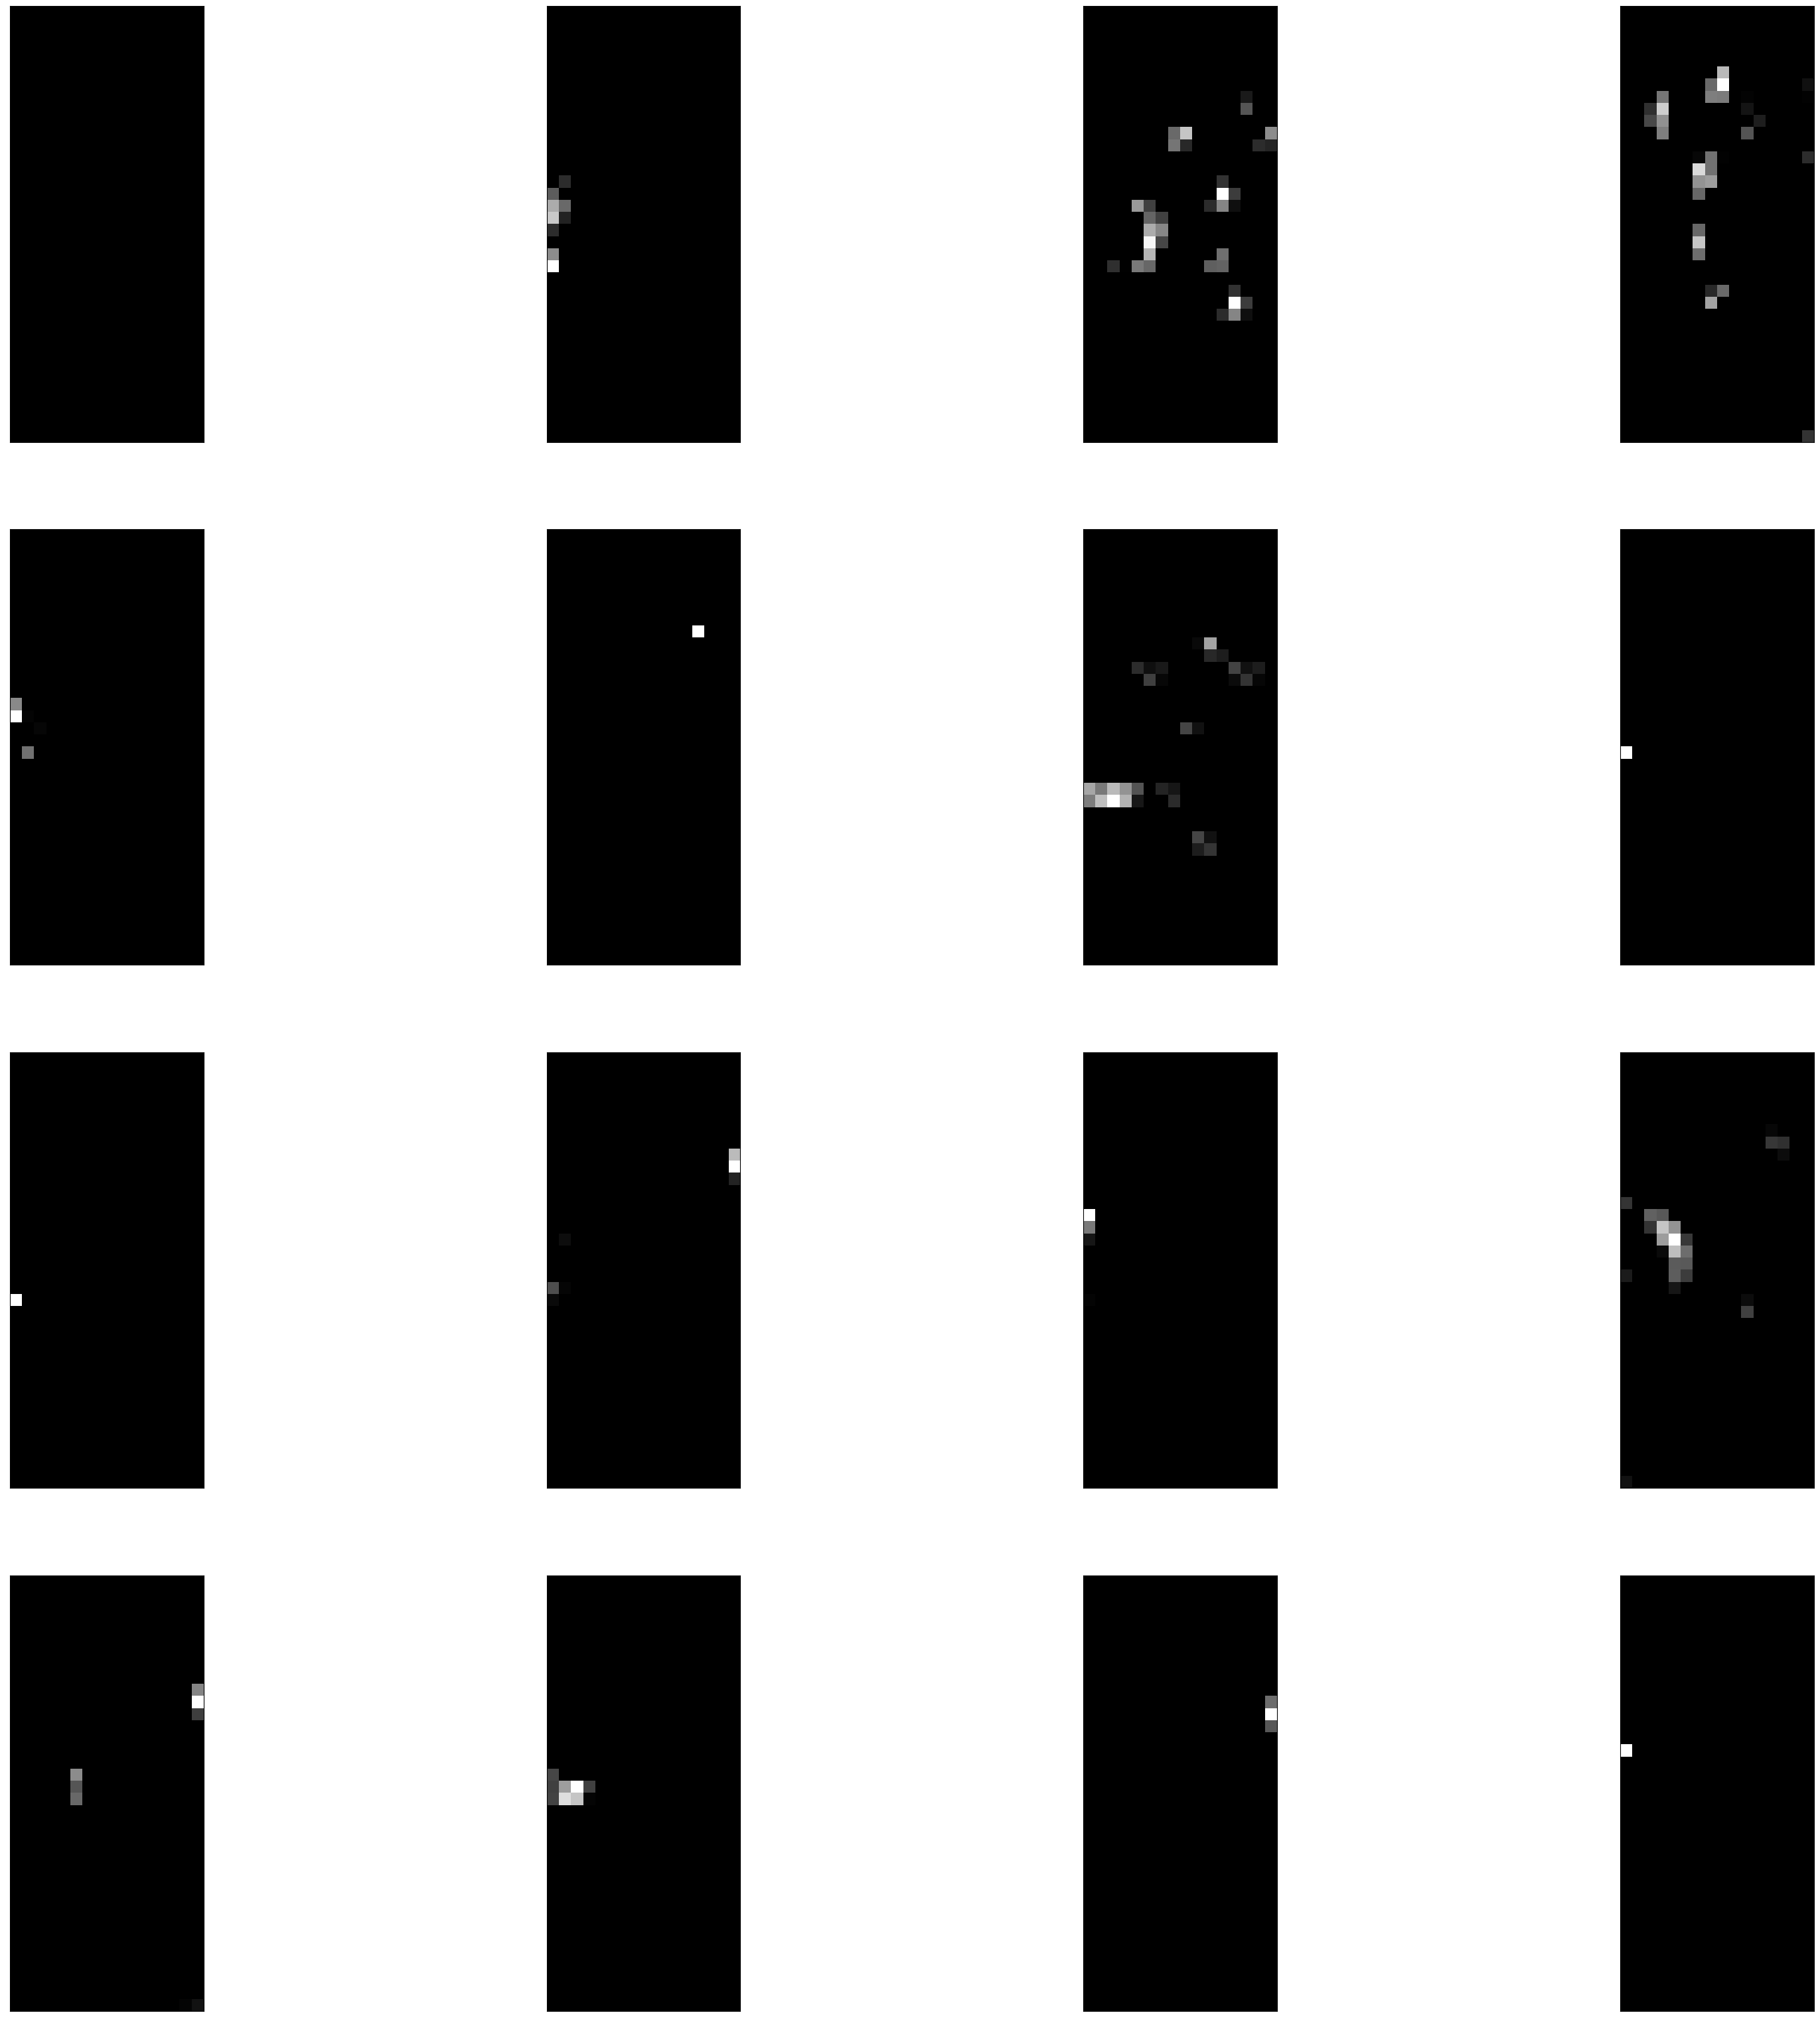

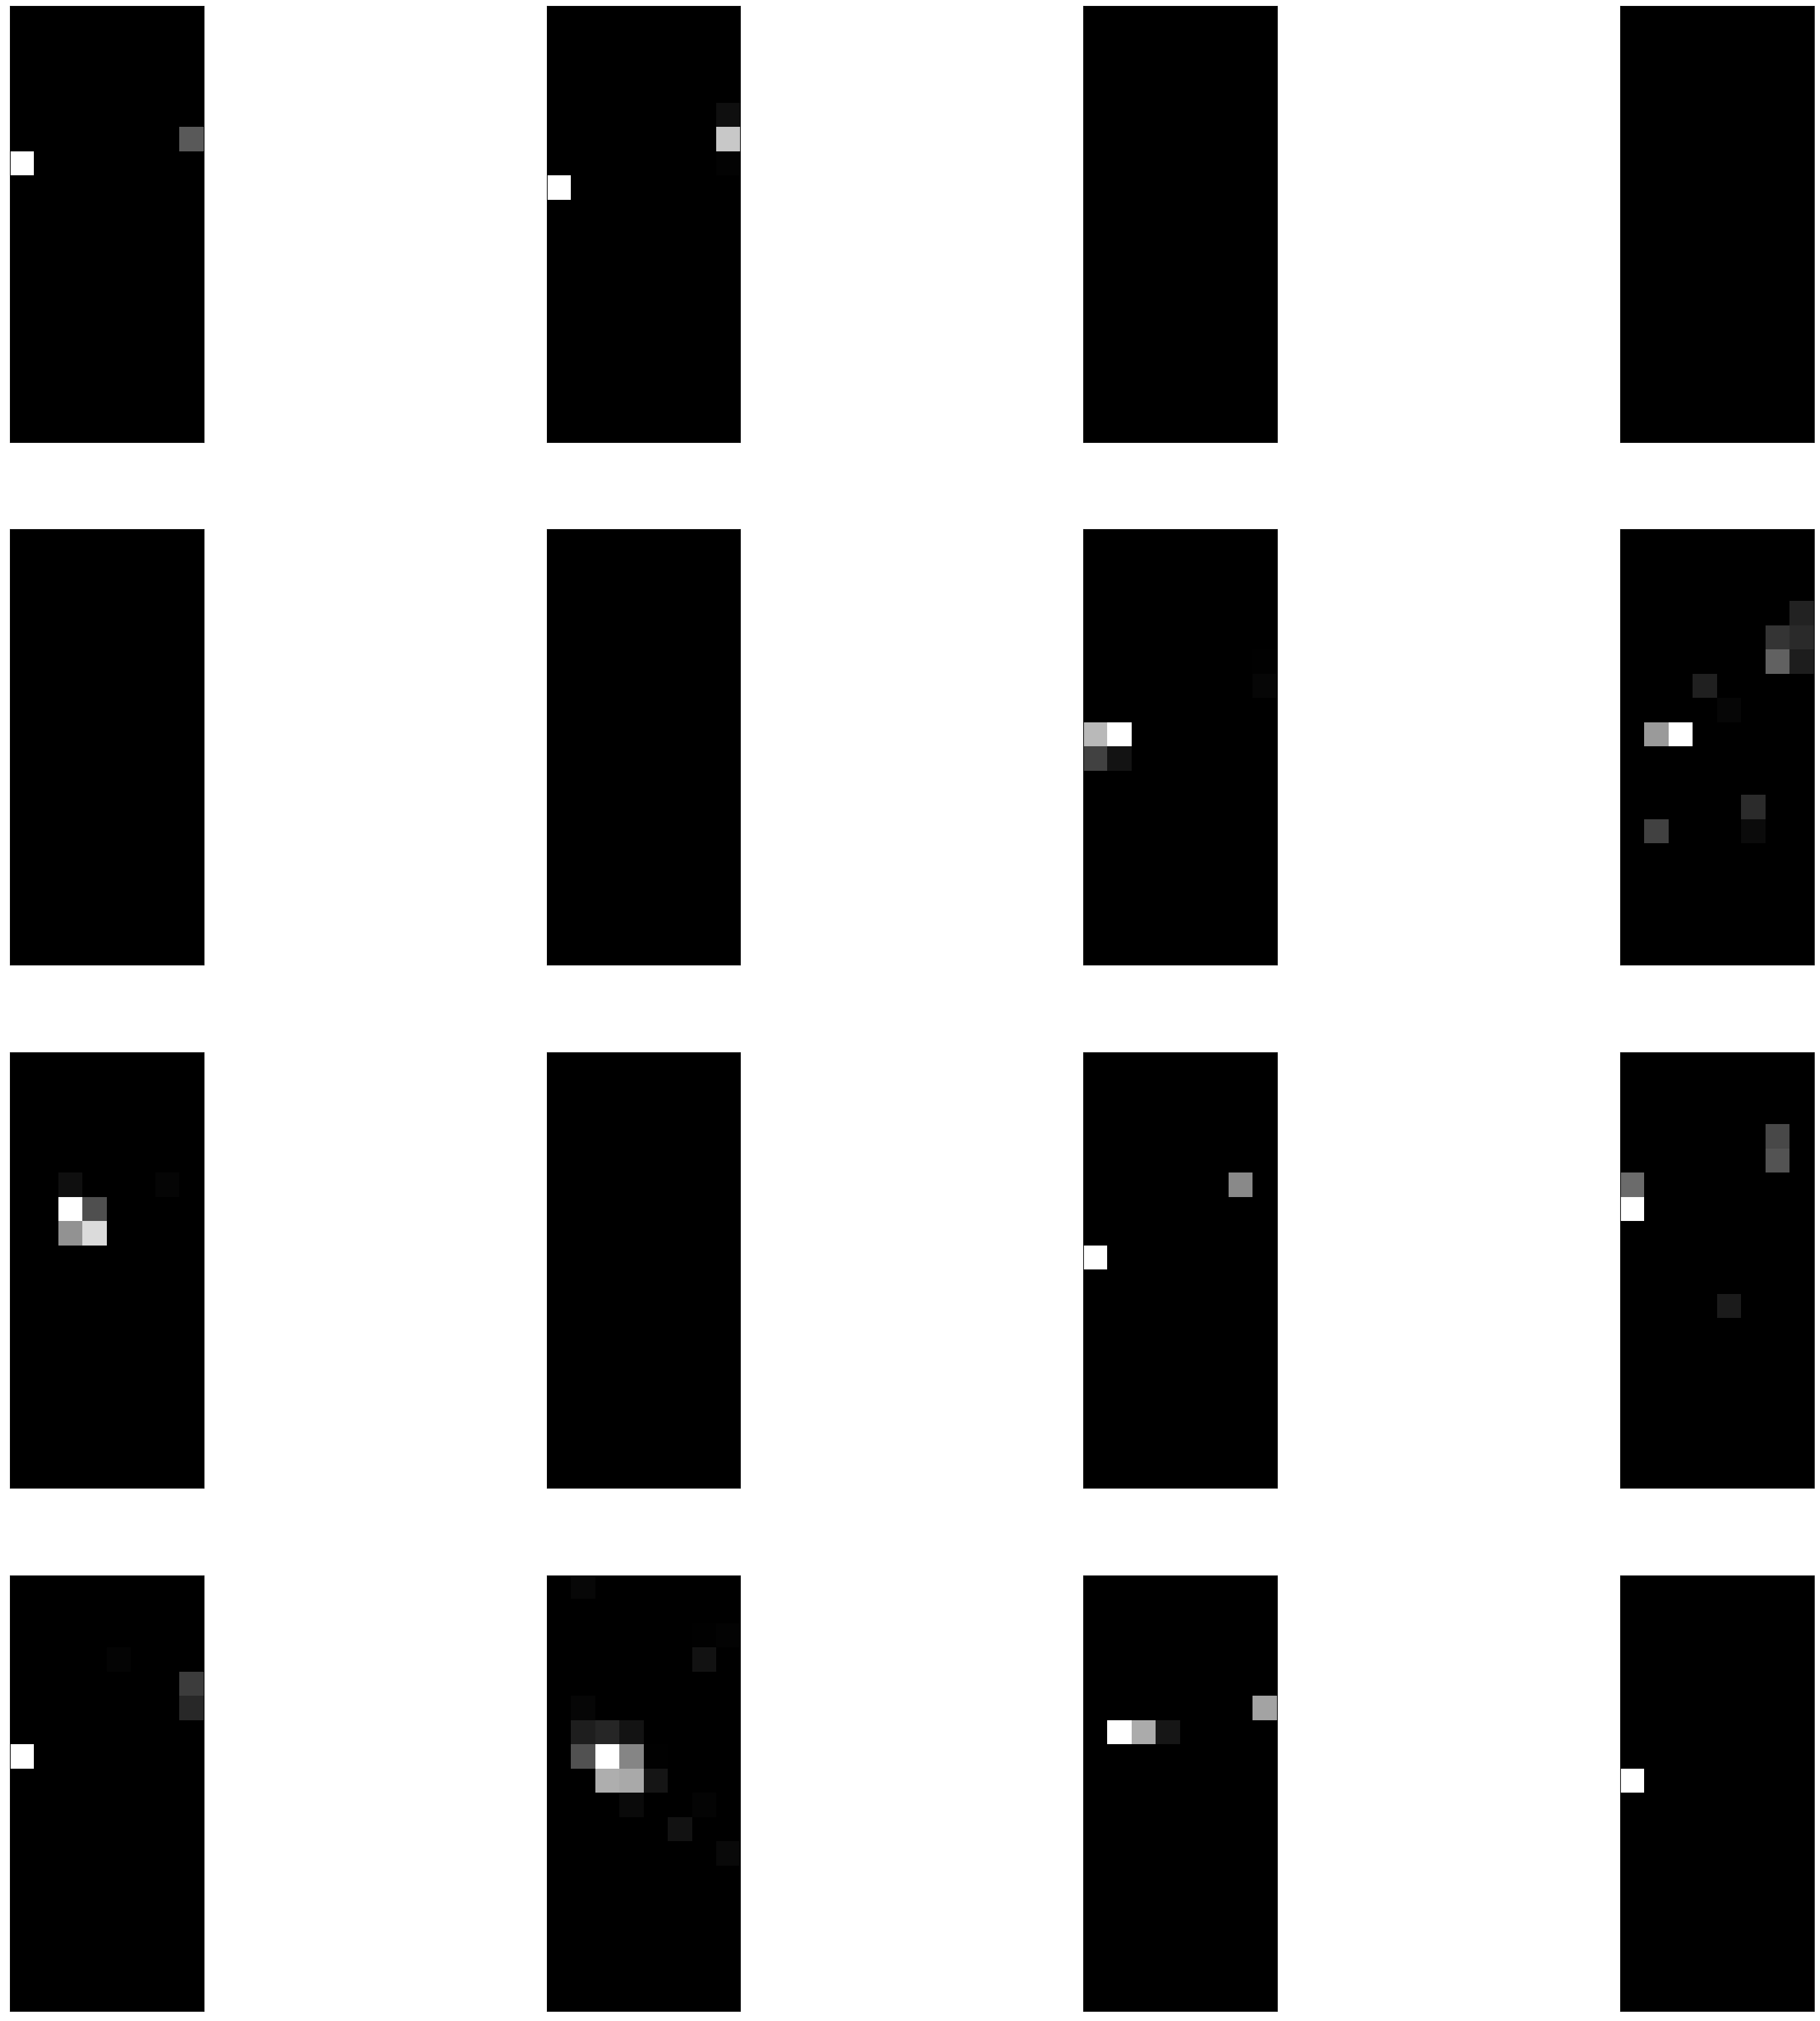

In [15]:
# visualize feature maps output from each block in the vgg model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

plt.rcParams['figure.figsize'] = [40, 40]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#model = VGG16()
#model = tf.keras.models.load_model("models/plain-mcbm-2022-02-08_1204.model")
model.summary()
ixs = [1, 3, 5, 7]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)

img = X[0]
#img = cv2.merge((img,img,img))
#img = cv2.resize(img, (224,224), interpolation=cv2.INTER_AREA)
img = np.expand_dims(img, axis=0)
feature_maps = model.predict(img)

square = 4
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()